## Import Libraries

In [104]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2, f_classif, SelectFpr
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import LinearSVC as svc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import time
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import ComplementNB as nb
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import AdaBoostClassifier as abc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier as sgd
from sklearn.ensemble import GradientBoostingClassifier as gbc
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.evaluate import bias_variance_decomp as bvd
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV as calibrate
from sklearn.ensemble import VotingClassifier

## Import Training Data

In [108]:
# import training data and print the shape
data = pd.read_csv('./clean_train.csv')
print(data.shape)
data.head(6)

(80398, 3)


,clean,lemm,label
0,new kind two dimensional carbon allotrope grap...,new kind two dimensional carbon allotrope grap...,Composites
1,astm standards volumes pages american society ...,astm standard volume page american society tes...,Vinyl
2,single photon photoionization mass spectrometr...,single photon photoionization mass spectrometr...,Particulate matter
3,molecular crystal structure hydrated form chit...,molecular crystal structure hydrate form chito...,Crystal structure
4,first silacobaltocenophane mesi ch co synthesi...,first silacobaltocenophane mesi ch co synthesi...,Crystal structure
5,development thermal sintering method cu based ...,development thermal sinter method cu base ink ...,Composites


## Feature Extraction

- CountVector vs TFIDF
- Original vs Lemmatized
- Ngram

### CountVector/TFIDF Examples

In [3]:
# print the top 6 features in count vector and tfidf vector
count_vector = CountVectorizer(max_features=6) # define count vector
count_mat = count_vector.fit_transform(data.clean)
names = count_vector.get_feature_names()
count_df = pd.DataFrame(count_mat.toarray(), columns=names)

tfidf_vector = TfidfVectorizer(max_features=6) # define tfidf vector
tfidf_mat = tfidf_vector.fit_transform(data.clean)
tfidf_df = pd.DataFrame(tfidf_mat.toarray(), columns=names)
pd.concat([count_df, tfidf_df], axis='columns', keys=['CountVector', 'TFIDF']).head(6)

CountVector                                            TFIDF             \
         high properties structure surface two using      high properties   
0           1          1         0       0   1     0  0.535758   0.608964   
1           0          0         0       0   0     0  0.000000   0.000000   
2           1          0         1       0   2     0  0.382196   0.000000   
3           0          0         3       0   0     0  0.000000   0.000000   
4           1          0         0       0   0     1  0.695719   0.000000   
5           0          0         0       0   0     2  0.000000   0.000000   

                                         
  structure surface       two     using  
0  0.000000     0.0  0.584916  0.000000  
1  0.000000     0.0  0.000000  0.000000  
2  0.396853     0.0  0.834526  0.000000  
3  1.000000     0.0  0.000000  0.000000  
4  0.000000     0.0  0.000000  0.718315  
5  0.000000     0.0  0.000000  1.000000

### Ngram(Original vs Lemmatized)

In [4]:
# train-test split for original text and lemmatized text
X_train0, X_test0, y_train0, y_test0 = train_test_split(data.clean, data.label, test_size=.3, 
                                                        random_state=9, stratify=data.label)
X_train, X_test, y_train, y_test = train_test_split(data.lemm, data.label, test_size=.3, 
                                                    random_state=9, stratify=data.label)

In [5]:
#  define function to get prediction and scores
def get_predict(model, X, Y, mode):
    pred = model.predict(X)
    return [pred, f1_score(y_true=Y, y_pred=pred, average=mode)]

In [6]:
#  define function to test ngram effect
def fit_count_ngram(m, n, clf, x, y):
    return Pipeline([('count', CountVectorizer(ngram_range=(m,n))), ('clf', clf)]).fit(x, y)

def fit_tfidf_ngram(m, n, clf, x, y):
    return Pipeline([('tfidf', TfidfVectorizer(ngram_range=(m,n), sublinear_tf=True)), ('clf', clf)]).fit(x, y)

C:\Users\LittleFatCat\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


The elapsed time is 7.449094847838084


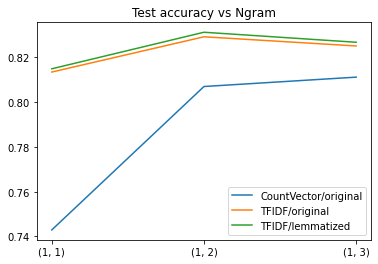

In [7]:
# compute test score using different ngrams
# plot the results for different feature combinations
start = time.time()

m = 1
n_range = [1, 2, 3]
clf = svc()
# call the function defined above
ngram_score = [[get_predict(fit_count_ngram(m, n, clf, X_train0, y_train0), X_test0, y_test0, 'micro')[1],
                 get_predict(fit_tfidf_ngram(m, n, clf, X_train0, y_train0), X_test0, y_test0, 'micro')[1],
                 get_predict(fit_tfidf_ngram(m, n, clf, X_train, y_train), X_test, y_test, 'micro')[1]] for n in n_range]

print('The elapsed time is', (time.time() - start)/60)

ngram = [str((m,n_range[0])), str((m,n_range[1])), str((m,n_range[2]))] # define x-axis ticks
plt.plot(ngram, [item[0] for item in ngram_score]);
plt.plot(ngram, [item[1]for item in ngram_score]);
plt.plot(ngram, [item[2] for item in ngram_score]);
plt.title('Test Score vs Ngram')
plt.legend(['CountVector/original', 'TFIDF/original', 'TFIDF/lemmatized'])
plt.show()

## Classifier Comparison

- Linear SVM
- Logistic Regression
- KNN
- Naive Bayes
- Random Forest
- AdaBoost

In [8]:
# define function to test effect of different features
def tune_params(numfeatures, p, clf, mode):
    
    mod = Pipeline([('tfidf_vector', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True,
                                                     min_df=2, max_df=.9, max_features=numfeatures)),
                    ('chi2', SelectFpr(chi2, alpha=p)),
                    ('clf', clf)]).fit(X_train, y_train)

    train_score = get_predict(mod, X_train, y_train, mode)[1]
    test_score = get_predict(mod, X_test, y_test, mode)[1]
        
    return [train_score, test_score]

In [9]:
# define function to plot the train-test scores
def plot_score(feature_range, score, title, xlab, plot_coord):

    train_score = [item[0] for item in score] # convert input to train score
    test_score = [item[1] for item in score] # convert input to test score
    # compute the train-test difference
    norm_score = (np.array(train_score) - np.array(test_score))/np.array(train_score)*100
    
    if plot_coord is None:
        ax1 = plt.subplot()
    else:
        ax1 = plt.subplot(plot_coord[0], plot_coord[1], plot_coord[2])
    ax2 = ax1.twinx()
    ax1.plot(feature_range, norm_score, 'b-')
    ax2.plot(feature_range, test_score, 'g-')
    ax1.set_title(title)
    ax1.set_xlabel(xlab)
    ax1.set_ylabel('%Diff of Training Score', color='b');
    ax2.set_ylabel('Testing Score', color='g');

In [10]:
# compute score for different k in knn
start = time.time()

k_range = [1, 9, 27] # define k values
k_score = [tune_params(None, 1, knn(n_neighbors=k, n_jobs=-1), 'micro') for k in k_range]

print('The elapsed time is', (time.time() - start)/60)

The elapsed time is 8.467625411351522


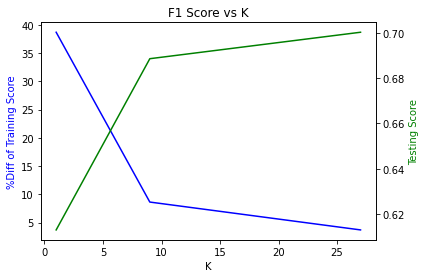

In [11]:
#  plot the score agianst k
plot_score(k_range, k_score, 'F1 Score vs K', 'K', None)
plt.show()

In [12]:
# use cross-validation to check the performance of classifiers listed
start = time.time()

svm_clf = svc() # linear svc
sgd_clf = sgd(loss='modified_huber', n_jobs=-1) # sgd
lr_clf = lr(solver='saga', n_jobs=-1) # logistic regression
knn_clf = knn(n_neighbors=9, n_jobs=-1) # knn
nb_clf = nb() # naive bayes
rf_clf = rf(n_jobs=-1) # random forest
abc_clf = abc() # adaboost
gbc_clf = gbc() # gradient boosting

clf_list = [svm_clf, sgd_clf, lr_clf, knn_clf, nb_clf, rf_clf, abc_clf, gbc_clf]
num_cv = 6
cv_result1 = [cross_validate(Pipeline([('tfidf_vector', TfidfVectorizer(ngram_range=(1,2), sublinear_tf=True, 
                                                                        max_features=2000)), ('clf', clf)]), 
                            data.lemm, data.label, cv=num_cv, scoring='f1_micro', n_jobs=-1, verbose=1) for clf in clf_list]

print('Elapsed time: %.3f' % ((time.time() - start)/60))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   43.6s remaining:   21.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   44.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   36.9s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   37.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   38.8s remaining:   19.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   39.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  2.4min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parall

Elapsed time: 69.152


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 57.1min finished


In [87]:
# define function to convert the corss-validation result to dataframe
def cv2df(num_cv, cv_result, clf_list, score_metric, mod_name):
    cv_df = pd.DataFrame(index=range(num_cv * len(clf_list)))
    cols = []
    for i in range(len(clf_list)):
        # get classifier name
        model_name = mod_name[i] + '\n' + '(' + str(round(np.mean(cv_result[i]['fit_time']))) + 's)'
        for fold_idx, accuracy in enumerate(cv_result[i][score_metric]):
            # store the result into columns
            cols.append((model_name, fold_idx, accuracy))       
    cv_df = pd.DataFrame(cols, columns=['classifier (fit time)', 'fold_idx', 'score'])
    return cv_df

In [88]:
# define function to plot the cross-validated dataframe
def plot_cv(num_cv, cv_result, clf_list, score_metric, mod_name):
    
    cv_df = cv2df(num_cv, cv_result, clf_list, score_metric, mod_name)
    sns.boxplot(x='classifier (fit time)', y='score', data=cv_df)
    sns.stripplot(x='classifier (fit time)', y='score', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
    plt.title('6-Fold Cross-Validated Test Score')
    plt.xticks(rotation=60)
    plt.show()

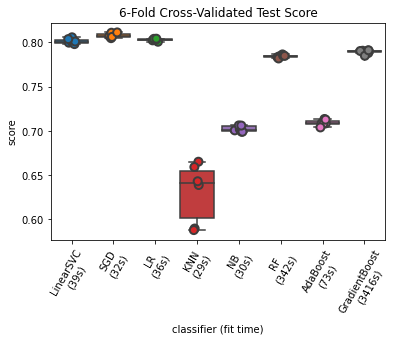

In [90]:
clf_name = ['LinearSVC', 'SGD', 'LR', 'KNN', 'NB', 'RF', 'AdaBoost', 'GradientBoost']
plot_cv(num_cv, cv_result1, clf_list, 'test_score', clf_name)

## Feature Selection

### TFIDF

In [16]:
# compute the score using different subset of tfidf
# using svc, sgd, lr and rf
start = time.time()

# max_features for tfidf
n_range1 = np.linspace(1, 10, 10, dtype=int) * 100
n_range2 = np.linspace(20, 100, 10, dtype=int) * 100
n_range3 = np.linspace(200, 1000, 10, dtype=int) * 100
n_range4 = np.linspace(200, 1000, 10, dtype=int) * 1000
n_range = [list(n_range1) + list(n_range2) + list(n_range3) + list(n_range4),
           list(n_range1) + list(n_range2) + list(n_range3),
           list(n_range1) + list(n_range2), list(n_range1) + list(n_range2)]

clf_list = [svm_clf, sgd_clf, lr_clf, rf_clf]
name_list = ['SVM', 'SGD', 'LR', 'RF']
tfidf_score = []
for i in range(len(clf_list)):
    print(name_list[i] + '...')
    tfidf_score.append([tune_params(n, 1, clf_list[i], 'micro') for n in n_range[i]])

print('Elapsed time: %.3f' % ((time.time() - start)/60))

SVM...
SGD...
LR...
RF...
Elapsed time: 74.562


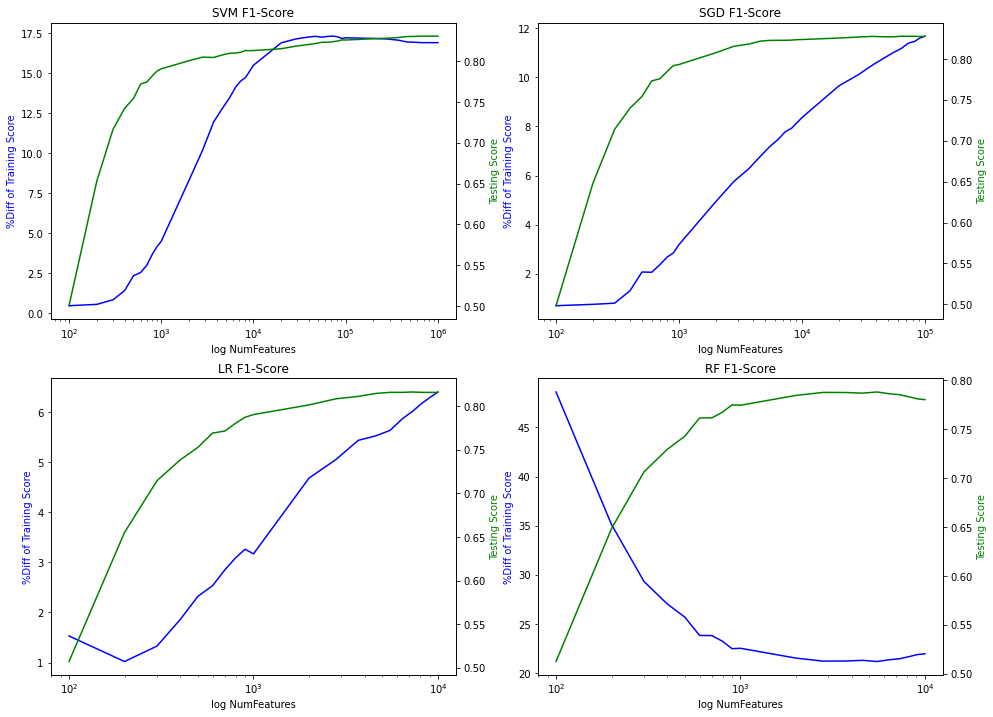

In [17]:
fig = plt.figure(figsize=(16,12))

for i in range(len(clf_list)):
    plot_score(n_range[i], tfidf_score[i], name_list[i] + ' F1-Score', 'log NumFeatures', (2,2,i+1))
    plt.xscale('log')
plt.show()

In [18]:
# store the number of macimum feature that has highest test score
num = []
for ind in range(4):
    m = [item[1] for item in tfidf_score[ind]].index(max([item[1] for item in tfidf_score[ind]]))
    num.append(n_range[ind][m])
print(num)

[733000, 64400, 7300, 5500]


### Chi2 vs ANOVA

In [19]:
# compute the feature selection using chi2 and anova
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
tfidf_lemm = tfidf_vectorizer.fit_transform(data.lemm)
chi2_test = chi2(tfidf_lemm, data.label)
anova_test = f_classif(tfidf_lemm, data.label)

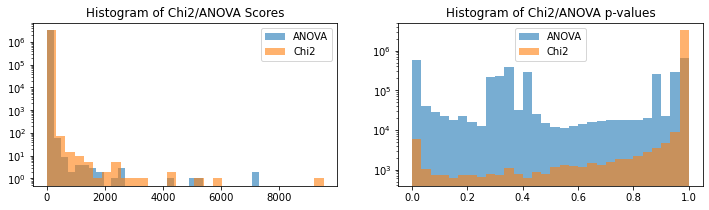

In [20]:
# plot the scores from the two tests
fig = plt.figure(figsize=(12,3))
plt_title = ['Scores', 'p-values']
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.hist(anova_test[i], alpha=.6, bins=30);
    plt.hist(chi2_test[i], alpha=.6, bins=30);
    plt.legend(['ANOVA', 'Chi2'])
    plt.title('Histogram of Chi2/ANOVA ' + plt_title[i])
    plt.yscale('log')
plt.show()

In [21]:
# convert the result above to dataframe for visulization
tfidf_name = tfidf_vectorizer.get_feature_names()
chi2_df = pd.DataFrame(pd.Series(chi2_test[0], index=tfidf_name).sort_values(ascending=False), columns=['chi2'])
anova_df = pd.DataFrame(pd.Series(anova_test[0], index=tfidf_name), columns=['anova'])
chi2_anova_df = pd.concat([chi2_df, anova_df], axis=1)

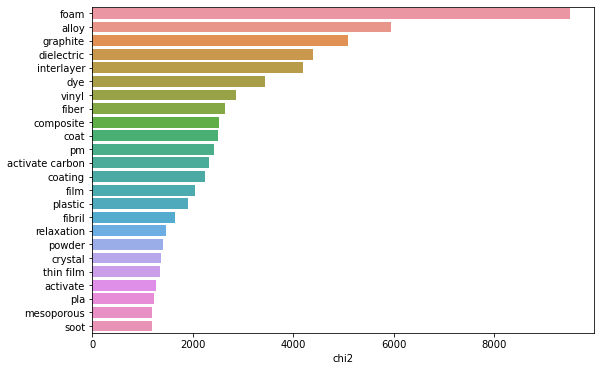

In [22]:
# plot the top features in chi2 test
df = chi2_anova_df[:24]
fig = plt.figure(figsize=(9,6))
sns.barplot(y=df.index, x='chi2', data=df, orient='h');

In [23]:
# compute the scores for different chi2 p-values
start = time.time()

# p-values
p_range = [1e-5, 1e-4, 1e-3, .01, .025, .05, .075, .1, .25, .35, .5, .65, .75, .85, .95]
chi2_score = []

for i in range(len(clf_list)):
    print(name_list[i] + '...')
    chi2_score.append([tune_params(num[i], p, clf_list[i], 'micro') for p in p_range])

print('Elapsed time: %.3f' % ((time.time() - start)/60))

SVM...
SGD...
LR...
RF...
Elapsed time: 40.439


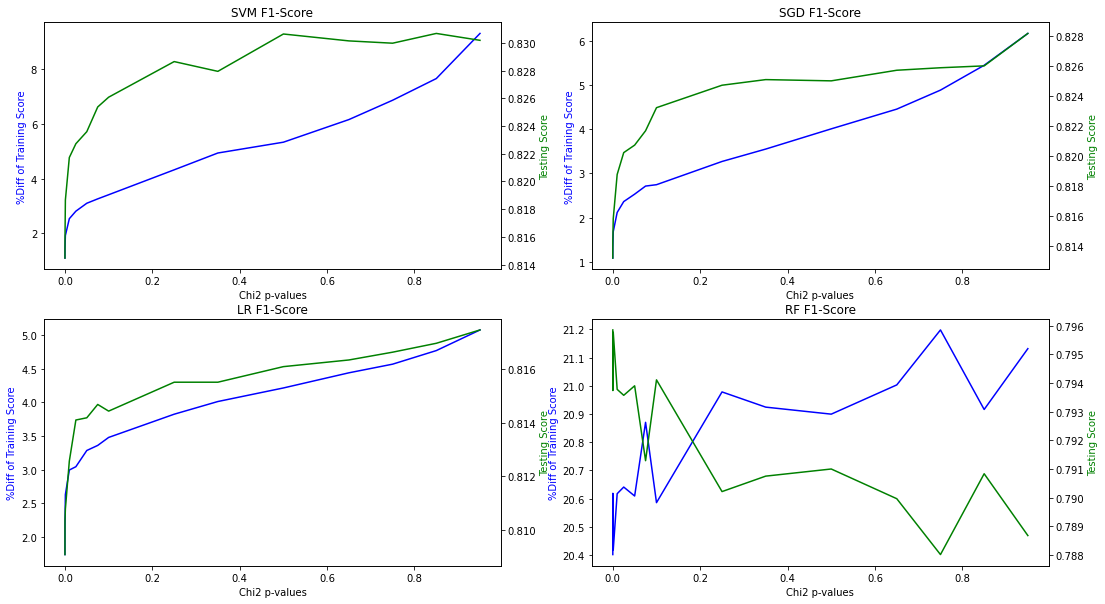

In [24]:
# visualize the result
fig = plt.figure(figsize=(18,10))
for i in range(len(clf_list)):
    plot_score(p_range, chi2_score[i], name_list[i] + ' F1-Score', 'Chi2 p-values', (2,2,i+1))
plt.show()

In [79]:
# define the p-values for each classifier
p = [.5, .35, 1e-5, 1e-5]

## Dimentionality Reduction

In [26]:
# define function to compute the tfidf matrix
def get_mat(numfeatures):
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=.9, sublinear_tf=True, max_features=numfeatures)
    return tfidf.fit_transform(data.lemm)

In [27]:
# compute the tfidf matrix using different max_features
mat = []
for i in range(4):
    mat.append(get_mat(num[i]))

In [28]:
# define function to compute chi2 selection
def chi2_selection(p_value, x, y):
    return SelectFpr(chi2, alpha=p_value).fit_transform(x, y)

In [80]:
# compute the selection using different p-values
# print out the matrix dimension
chi2_mat = []
print('Original size:', tfidf_lemm.shape)
for i in range(4):
    chi2_mat.append(chi2_selection(p[i], mat[i], data.label))
    print('Selection for ' + name_list[i] + ':', chi2_mat[i].shape)

Original size: (80398, 3325864)
Selection for SVM: (80398, 15907)
Selection for SGD: (80398, 12834)
Selection for LR: (80398, 2571)
Selection for RF: (80398, 2264)


In [31]:
# define function to compute the variance and fit time for truncated svd
def get_var(dim, selection):

    t1 = time.time()
    
    tsvd = TruncatedSVD(n_components=dim, random_state=0)
    tsvd_fit = tsvd.fit(selection)
    var = round(tsvd.explained_variance_ratio_.sum(), 3) * 100
    dt = round((time.time() - t1)/60, 3)
    
    return [var, dt, tsvd_fit]

In [81]:
# compute ttruncated svd
start = time.time()

dim_range = [10, 50, 100, 500, 1000, 1500, 2000] # define the dimension

var = [get_var(dim, chi2_mat[0]) for dim in dim_range]

print('Elapsed time: %.3f' % ((time.time() - start)/60))

Elapsed time: 6.193


In [44]:
# define function to plot the variance and time
def plot_var(dim_range, var_result, plot_coord):
    
    var = [item[0] for item in var_result] # convert input to train score
    dt = [item[1] for item in var_result] # convert input to teset score
    
    if plot_coord is None:
        ax1 = plt.subplot()
    else:
        ax1 = plt.subplot(plot_coord[0], plot_coord[1], plot_coord[2])
    ax2 = ax1.twinx()
    ax1.plot(dim_range, var, 'darkorange')
    ax2.plot(dim_range, dt, 'darkgoldenrod')
    ax1.set_title('%Variance Explained')
    ax1.set_xlabel('Dimensions')
    ax1.set_ylabel('%Variance', color='darkorange');
    ax2.set_ylabel('Processing Time', color='darkgoldenrod');

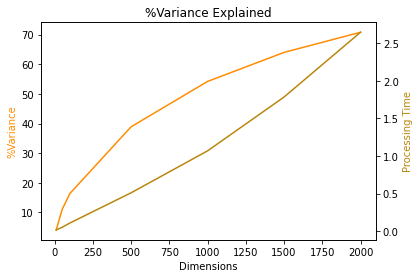

In [82]:
plot_var(dim_range, var, None)
plt.show()

In [47]:
# define function to compute score for different dimensions
def tune_tsvd(numfeatures, p, dim, clf, mode):
    
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=.9, sublinear_tf=True, max_features=numfeatures)
    mod = Pipeline([('tfidf_vector', tfidf),
                    ('chi2', SelectFpr(chi2, alpha=p)),
                    ('tsvd', TruncatedSVD(n_components=dim, random_state=0)), # add svd transformer into pipeline
                    ('clf', clf)]).fit(X_train, y_train)
    #compute train-test score
    train_score = get_predict(mod, X_train, y_train, mode)[1]
    test_score = get_predict(mod, X_test, y_test, mode)[1]
        
    return [train_score, test_score]

In [83]:
start = time.time()

dim_range2 = [100, 300, 500, 800, 1200] # define dimensions
tvsd_score = [tune_tsvd(num[0], p[0], dim, clf_list[0], 'micro') for dim in dim_range2]

print('Elapsed time: %.3f' % ((time.time() - start)/60))

Elapsed time: 8.354


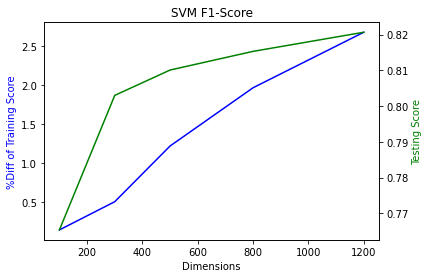

In [84]:
plot_score(dim_range2, tvsd_score, name_list[0] + ' F1-Score', 'Dimensions', None)
plt.show()

## Bias-Variance Tradeoff

In [54]:
# define fucntion to compute bias-variance tradeoff
def bv_tradeoff(num, p, clf, num_bootstrap, mode):
    
    pipe = Pipeline([('tfidf_vector', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=.9, 
                                                      sublinear_tf=True, max_features=num)), 
                     ('chi2', SelectFpr(chi2, alpha=p)), ('clf', clf)])
    
    le = LabelEncoder()
    encoded_label = le.fit_transform(data.label) # encode the label into number
    # train-test split using encoded label
    X_train, X_test, y_train, y_test = train_test_split(data.lemm.values, encoded_label, test_size=.3, 
                                                        random_state=9, stratify=encoded_label)
    # compute loss, bias, variance
    loss, bias, var = bvd(pipe, X_train, y_train, X_test, y_test, num_rounds=num_bootstrap, random_seed=0)
    # compute train-test scores
    train_score, test_score = tune_params(num, p, clf, mode)

    return [loss, bias, var, train_score, test_score]

In [85]:
start = time.time()

c_range = np.linspace(.05, .25, 5) # define regularization parameter
svm_bv = [bv_tradeoff(num[0], p[0], svc(C=c, dual=False), 3, 'micro') for c in c_range]

print('Elapsed time: %.3f' % ((time.time() - start)/60))

Elapsed time: 11.919


In [60]:
def plot_bv(feature_range, bv_result, title):
    
    bias = [round(item[1],3) for item in bv_result] # convert input to bias
    var = [item[2]*100 for item in bv_result] # convert input to variance

    plt.figure(figsize=(18,4))
    
    ax1a = plt.subplot(1,2,1)
    ax1b = ax1a.twinx()
    ax1a.plot(feature_range, bias, 'darkcyan')
    ax1b.plot(feature_range, var, 'm')
    ax1a.set_title('Bias-Variance Tradeoff')
    ax1a.set_xlabel('Model Complexity')
    ax1a.set_ylabel('bias', color='darkcyan')
    ax1b.set_ylabel('%variance', color='m')
    
    score = [[item[3],item[4]] for item in bv_result] # convert input to train-test score
    plot_score(feature_range, score, title, 'Model Complexity', (1,2,2))

    plt.show()

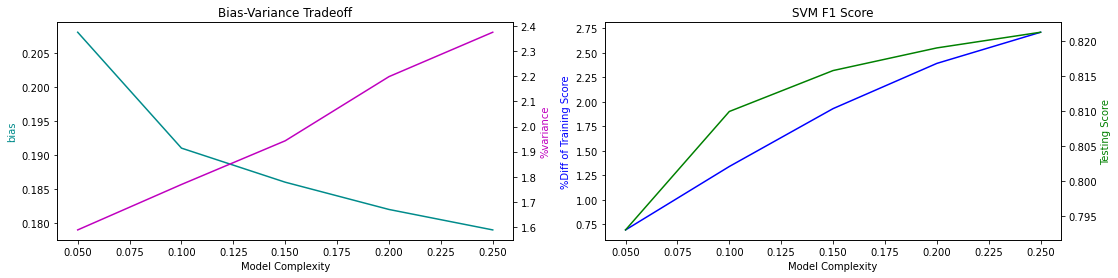

In [86]:
plot_bv(c_range, svm_bv, 'SVM F1 Score')

## Hyperparameter Tuning

In [62]:
# define function for hyperparameter tuning
def hyper_tuning(num, p, clf, dist, num_cv, num_iter, score_metric):
    
    # define pipeline
    pipe = Pipeline([('tfidf_vector', TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=.9, 
                                                      sublinear_tf=True, max_features=num)), 
                     ('chi2', SelectFpr(chi2, alpha=p)), ('clf', clf)])
    #define randomizedsearch classifier
    search_clf = RandomizedSearchCV(pipe, param_distributions=dist, cv=num_cv, n_iter=num_iter, 
                                    scoring=score_metric, n_jobs=-2, random_state=0)
    search = search_clf.fit(data.lemm, data.label)
    # store the best result
    result = search.best_estimator_ 
    print(search.best_score_) # print the best cv score
    return result

In [91]:
start = time.time()

num_cv = 5 # define number of cv
num_iter = 30 # define number of iteration to search
score_metric = 'f1_micro' # define scoring metric

# define parameter to tune for svm
svm_dist = {
    'clf__C': uniform(0, 5),
    'clf__intercept_scaling': uniform(0, 5),
}
# define parameter to tune for sgd
sgd_dist = {
    'clf__alpha': uniform(0, 1e-4),
}
# define parameter to tune for lr
lr_dist = {
    'clf__C': uniform(0, 5),
    'clf__intercept_scaling': uniform(0, 5),
}
# define parameter to tune for rf
rf_dist = {
    'clf__min_samples_split': [2, 6, 10],
    'clf__class_weight': [None, 'balanced'],
    'clf__ccp_alpha': uniform(0, 5e-6)
}

# perform tuning for the classifiers
clf_list = [svc(dual=False), sgd(loss='modified_huber', n_jobs=-2), lr(solver='saga', n_jobs=-2), rf(n_jobs=-2)]
dist_list = [svm_dist, sgd_dist, lr_dist, rf_dist]
tune = []
for i in range(len(clf_list)):
    print('Tuning ' + name_list[i] +'...')
    tune.append(hyper_tuning(num[i], p[i], clf_list[i], dist_list[i], num_cv, num_iter, score_metric))

print('Elapsed time: %.3f' % ((time.time() - start)/60))

Tuning SVM...
0.8277195820140545
Tuning SGD...
0.8276822825050072
Tuning LR...
0.8149083242287226
Tuning RF...
0.7976068998870317
Elapsed time: 155.525


In [106]:
# examine the parameters for each classifier
print(tune[0]['clf'])
print(tune[1]['clf'])
print(tune[2]['clf'])
print(tune[3]['clf'])

LinearSVC(C=1.0519128053692044, dual=False,
          intercept_scaling=0.6446314882742665)
SGDClassifier(alpha=3.8344151882577774e-05, loss='modified_huber', n_jobs=-2)
LogisticRegression(C=3.060478613612107, intercept_scaling=3.0846699843737846,
                   n_jobs=-2, solver='saga')
RandomForestClassifier(ccp_alpha=4.511742915869922e-06, class_weight='balanced',
                       min_samples_split=6, n_jobs=-2)


## Voting Meta Classifier

In [96]:
# since linearSVC and sgd do not have prediction probability
# using calibrated classifier to get theor prediction proba
svm_cal = Pipeline([('tfidf', tune[0]['tfidf_vector']), ('chi2', tune[0]['chi2']), 
                    ('clf', calibrate(base_estimator=tune[0]['clf'], n_jobs=-1))])
sgd_cal = Pipeline([('tfidf', tune[1]['tfidf_vector']), ('chi2', tune[1]['chi2']), 
                    ('clf', calibrate(base_estimator=tune[1]['clf'], n_jobs=-1))])

In [97]:
# cross-validation on all the classifiers including the base ones and voting ones
# using 3 scoring metrics: micro f1, macro f1 and roc-auc
start = time.time()

# define voting classifier using uniform weight
hard_vote = VotingClassifier(estimators=[('svm', svm_cal), ('sgd', sgd_cal), ('lr', tune[2]), ('rf', tune[3])], 
                             voting='soft', weights=[1,1,1,1])
# define voting classifier with weight using their scores
soft_vote = VotingClassifier(estimators=[('svm', svm_cal), ('sgd', sgd_cal), ('lr', tune[2]), ('rf', tune[3])], 
                             voting='soft', weights=[.8277, .8276, .8149, .7976])
# define the list to store all the classifier
pipe_list = [svm_cal, sgd_cal, tune[2], tune[3], hard_vote, soft_vote]
# perform cross-validation
cv_result2 = [cross_validate(pipe, data.lemm, data.label, scoring=['f1_micro', 'f1_macro', 'roc_auc_ovr'], 
                             n_jobs=-1, verbose=1) for pipe in pipe_list]

print('Elapsed time: %.3f' % ((time.time() - start)/60))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Elapsed time: 20.015


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


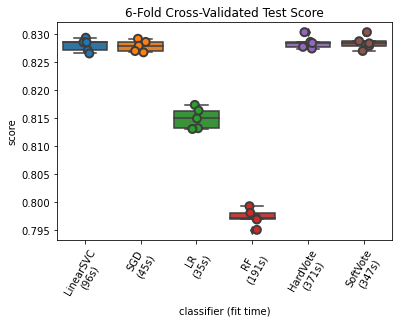

In [98]:
# plot micro f1
pipe_name = ['LinearSVC', 'SGD', 'LR', 'RF', 'HardVote', 'SoftVote']
plot_cv(5, cv_result2, pipe_list, 'test_f1_micro', pipe_name)

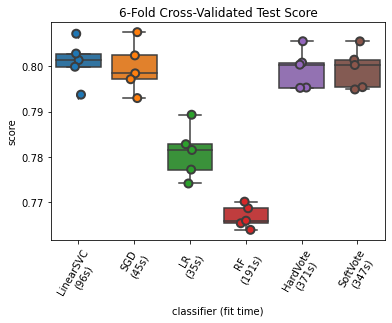

In [99]:
# plot macro f1
plot_cv(5, cv_result2, pipe_list, 'test_f1_macro', pipe_name)

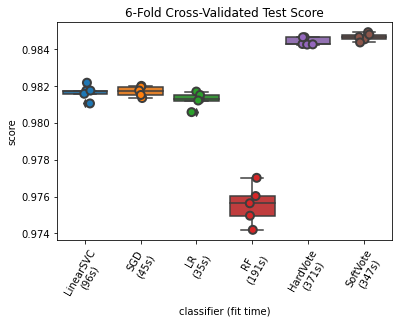

In [100]:
# plot roc-auc
plot_cv(5, cv_result2, pipe_list, 'test_roc_auc_ovr', pipe_name)

## Test Prediction

In [101]:
# load the test data
test = pd.read_csv('./clean_test.csv')
test.head()

,test_id,clean,lemm
0,1,edible air pollution menu ideas city street fe...,edible air pollution menu idea city street fes...
1,2,improved moisture stability desired cellulose ...,improve moisture stability desire cellulose bi...
2,3,mesoporous silica nanoparticles used fabricate...,mesoporous silica nanoparticles use fabricate ...
3,4,report simple versatile method preparation one...,report simple versatile method preparation one...
4,5,growth suitable protein crystals essential ste...,growth suitable protein crystal essential step...


In [102]:
# soft_vote is the final model
# prediction using soft_vote
model = soft_vote.fit(data.lemm, data.label)
pred = model.predict(test.lemm)

In [103]:
# output the prediction to csv
output = pd.DataFrame({'test_id':test.test_id, 'label':pred})
output.to_csv('./pred_labels.csv', index=False)